In [173]:
from xpeem_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from scipy.interpolate import CubicSpline
from numpy.random import *
from sklearn.metrics import  mean_squared_error,mean_absolute_error
from seaborn import heatmap
mpl.rcParams['figure.dpi'] = 300


Tests the accuracy of cosine similarity by introducing noise and shifts

Text(0, 0.5, 'Intensity (arb. u.)')

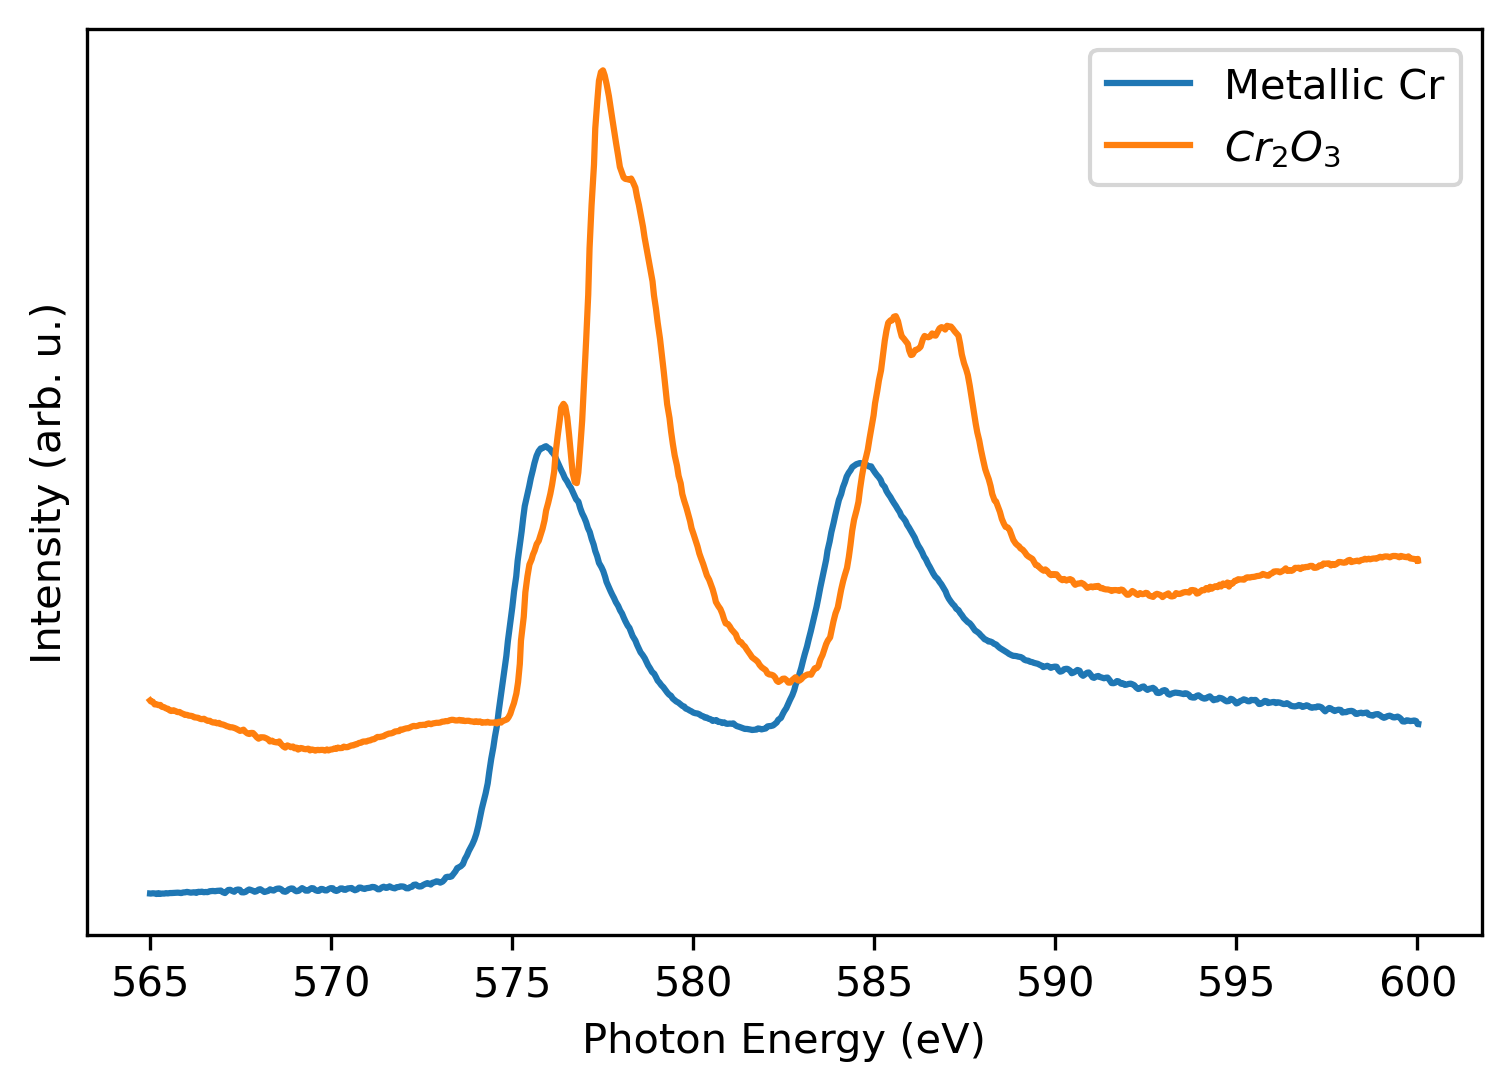

In [174]:
#Get the reference spectra
reference_spectra = pd.read_csv("Data/metal_oxide_XAS_ref.csv")
reference_spectra.head()
plt.plot(reference_spectra['Cr ref E'],reference_spectra['Cr ref'])
plt.plot(reference_spectra["Cr2o3 ref E"],reference_spectra['Cr2o3 ref'])

#Visualize the metal and oxide reference spectra
plt.legend(("Metallic Cr","$Cr_{2}O_{3}$"))
plt.yticks([])
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")

In [175]:
#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(reference_spectra['Cr ref E'],reference_spectra['Cr ref'])
oxide_ref_interp = CubicSpline(reference_spectra["Cr2o3 ref E"],reference_spectra['Cr2o3 ref'])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
xrange = np.arange(570,584.2,0.2)
metal_ref = normalize_array(metal_ref_interp(xrange))
oxide_ref = normalize_array(oxide_ref_interp(xrange))

This section detials how the cosine similarity was equated to reference spectra by creating a series of linear combinations, calculating the normalized cosine similarity for each, then fitting a function based on that correlation

(101, 72)


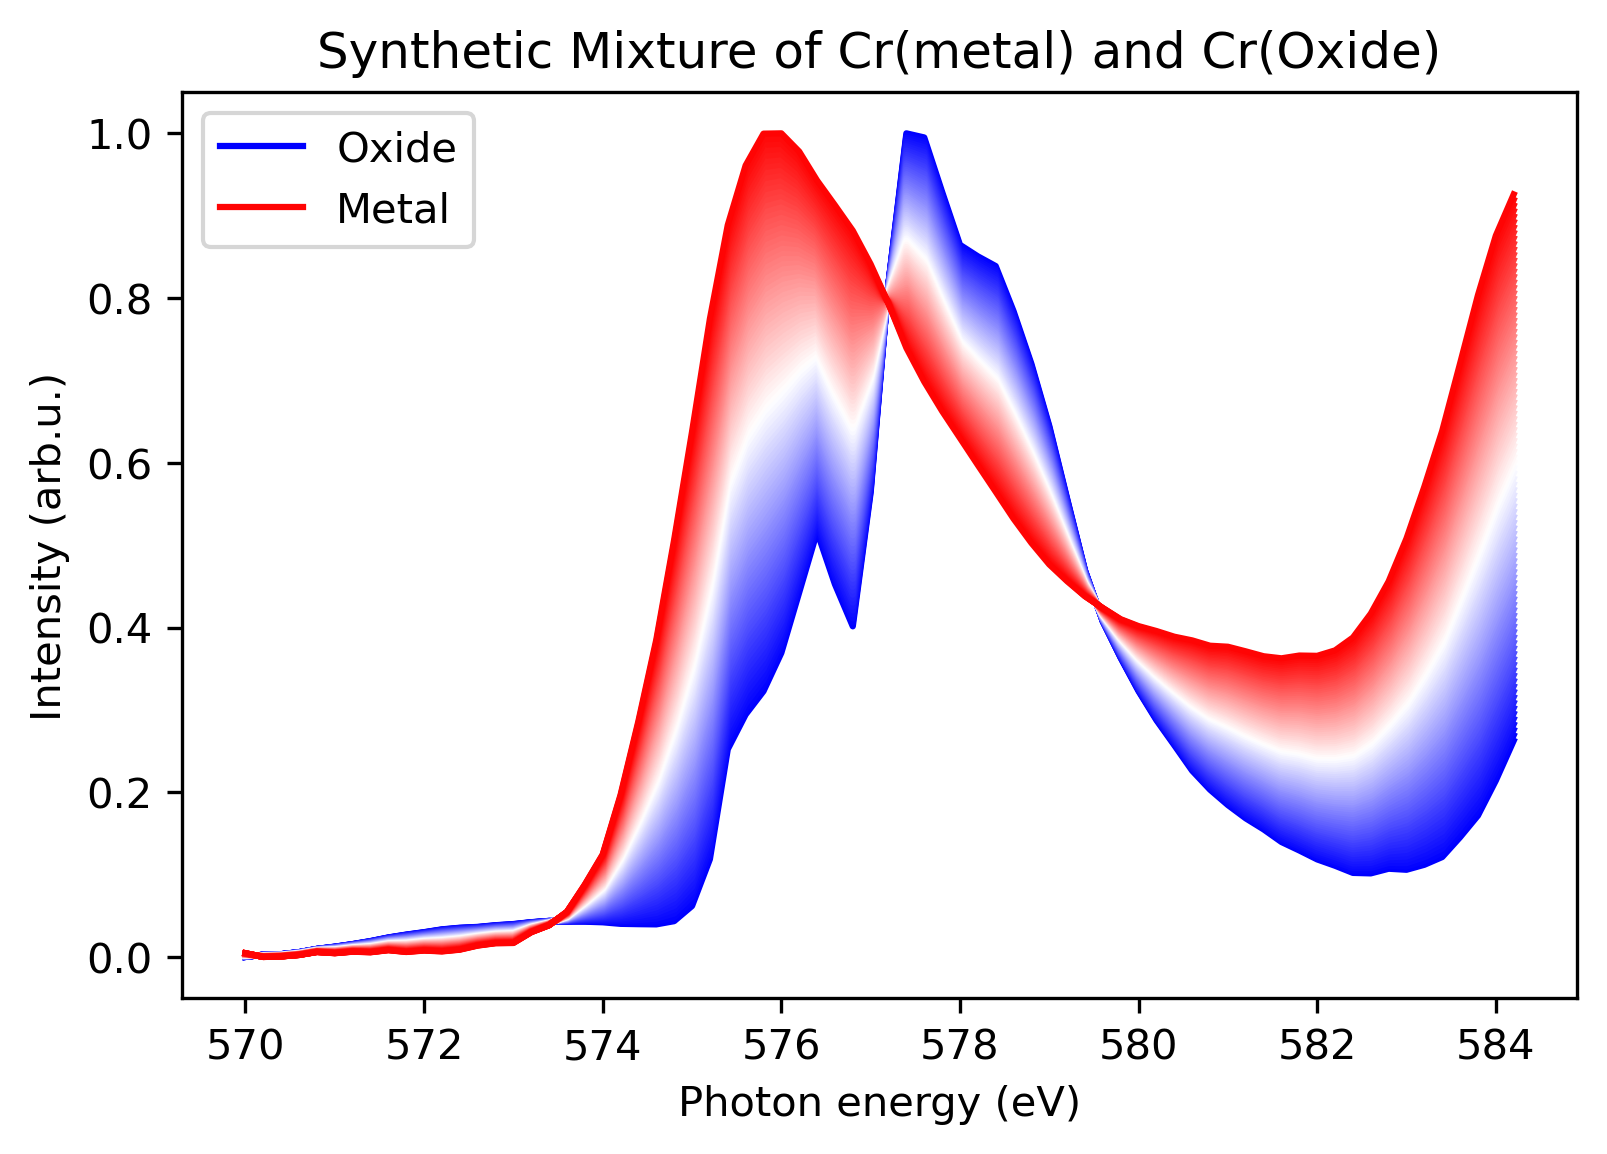

In [176]:
#Make a series of 100 linear combinations of metal and oxie reference spectra
percentrange = np.arange(0,1.01,.01)
#print(percentrange.shape)
synth = np.tile(percentrange,(len(metal_ref),1)).T
print(synth.shape)
synth_metal = np.tile(metal_ref,(len(percentrange),1))*synth
synth_oxide = np.tile(oxide_ref,(len(percentrange),1))*(1-synth)
synth_spectra = synth_metal+synth_oxide

#plot all the synthetic spectra
rb = plt.cm.get_cmap("bwr")
for i,row in enumerate(synth_spectra):
    if i == 0:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Oxide')
    elif i == len(synth_spectra)-1:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Metal')
    else:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='_nolegend_')
plt.ylabel('Intensity (arb.u.)')
plt.xlabel('Photon energy (eV)')
plt.title('Synthetic Mixture of Cr(metal) and Cr(Oxide)')
plt.legend()


[  76.59245144 -140.66832005   91.85717455  -19.75327203]


Text(0.5, 1.0, 'Cosine Similarity of known synthetic spectra')

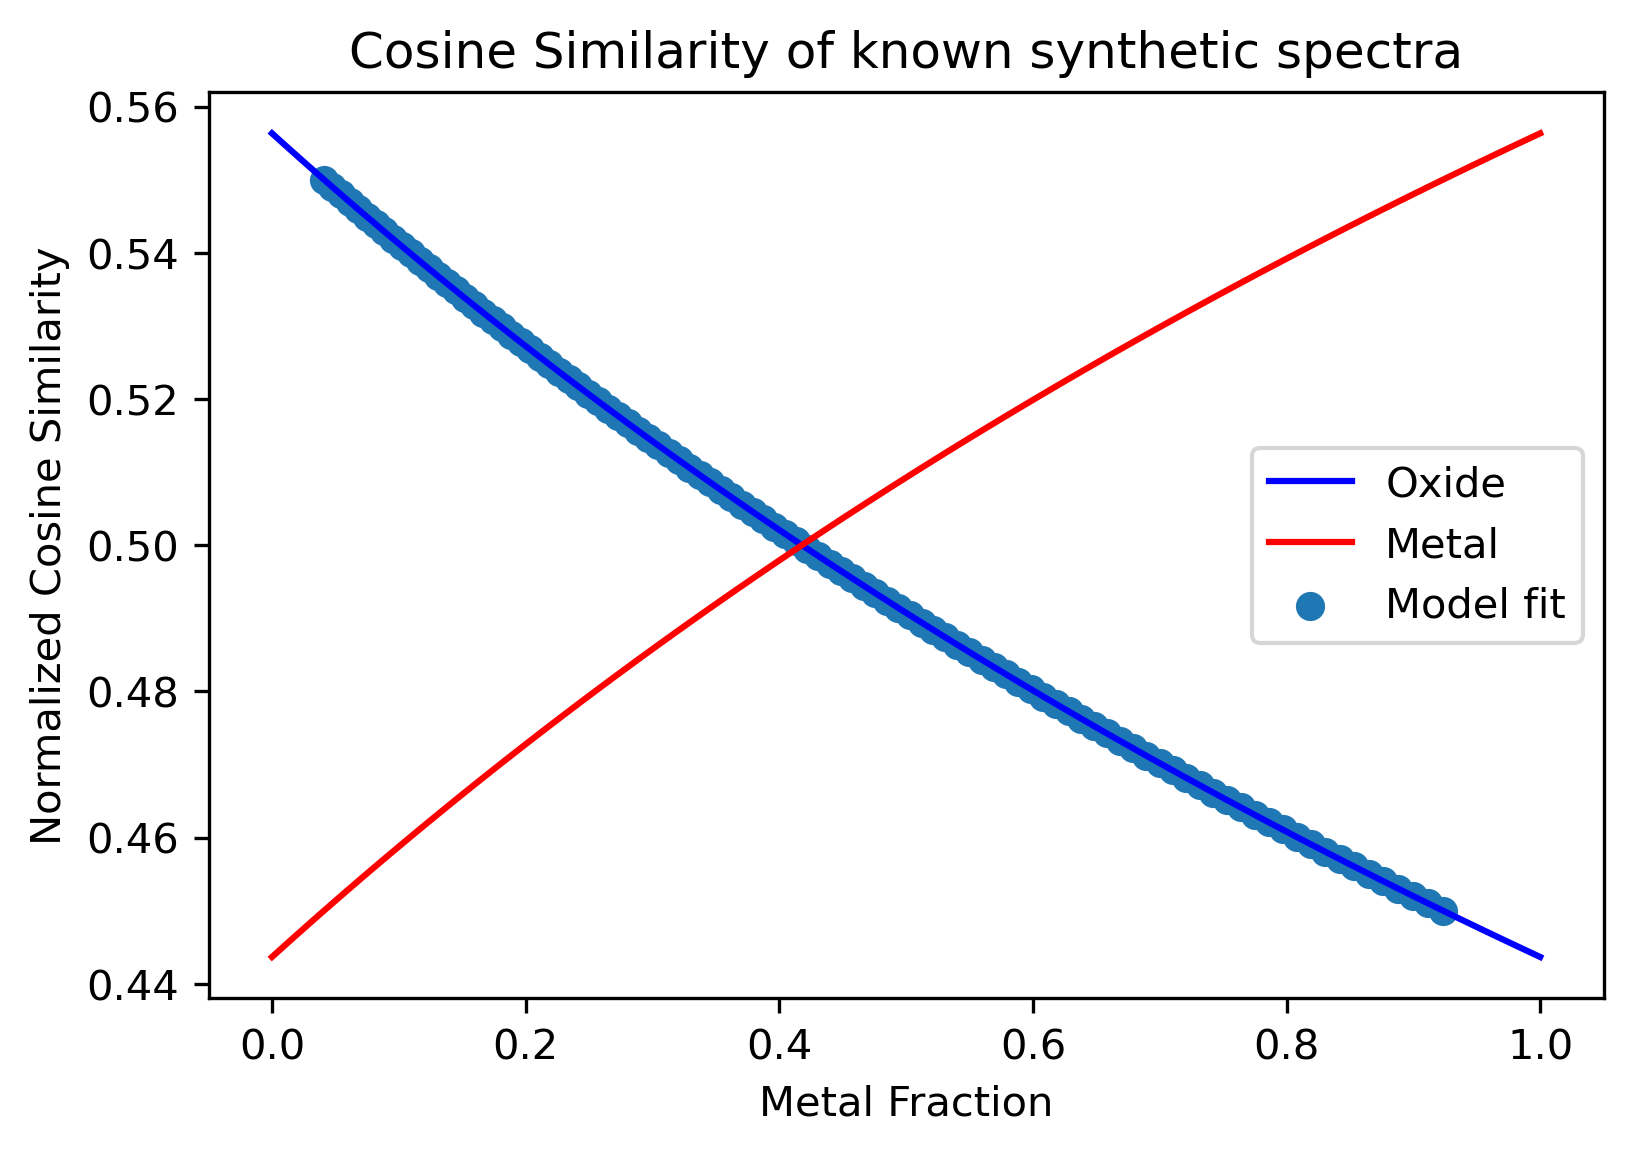

In [182]:
#calculate normalized cosine similarities for each synthetic mixture
oxide_cs_synth = np.zeros(percentrange.shape)
oxide_cs_list = np.zeros(percentrange.shape)
metal_cs_list = np.zeros(percentrange.shape)
for i, row in enumerate(synth_spectra):
    metal_cs = cosine_similarity_2d(row,metal_ref)
    oxide_cs = cosine_similarity_2d(row,oxide_ref)
    oxide_cs_synth[i] = oxide_cs/(metal_cs+oxide_cs)
    oxide_cs_list[i] = oxide_cs
    metal_cs_list[i] = metal_cs
params = np.polyfit(oxide_cs_synth,1-percentrange,3)
oxide_cs_to_percent_polyfit = np.poly1d(params)

print(params)
#Visualize the normalized cosine similarity vs known fraction in the synthetic spectra
#validation = oxide_cs_to_percent(np.linspace(.45,.55,100))/100
validation = oxide_cs_to_percent_polyfit(np.linspace(.45,.55,100))

#print(min(oxide_cs_synth),max(oxide_cs_synth))
plt.plot(percentrange,oxide_cs_synth, c='b')
plt.plot(percentrange,1-oxide_cs_synth,c='r')
plt.scatter(1-validation,np.linspace(.45,.55,100))
plt.legend(["Oxide","Metal","Model fit"])
plt.ylabel("Normalized Cosine Similarity")
plt.xlabel("Metal Fraction")
plt.title("Cosine Similarity of known synthetic spectra")

In [168]:
def make_synth_spectra(spline,shift):
    range = np.arange(570,584.2,0.2)-shift
    ref_spectra = normalize_array(spline(range))
    return ref_spectra

def make_test_synths(synth_metal_ref,synth_oxide_ref,n_spectra,concentrations):
    synth_concentrations = np.tile(concentrations,(len(synth_metal_ref),1)).T
    #print(synth_concentrations)
    synth_metal = np.tile(synth_metal_ref,(n_spectra,1))*synth_concentrations
    synth_oxide = np.tile(synth_oxide_ref,(n_spectra,1))*(1-synth_concentrations)
    synth_spectra = synth_metal+synth_oxide
    return synth_spectra

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18]


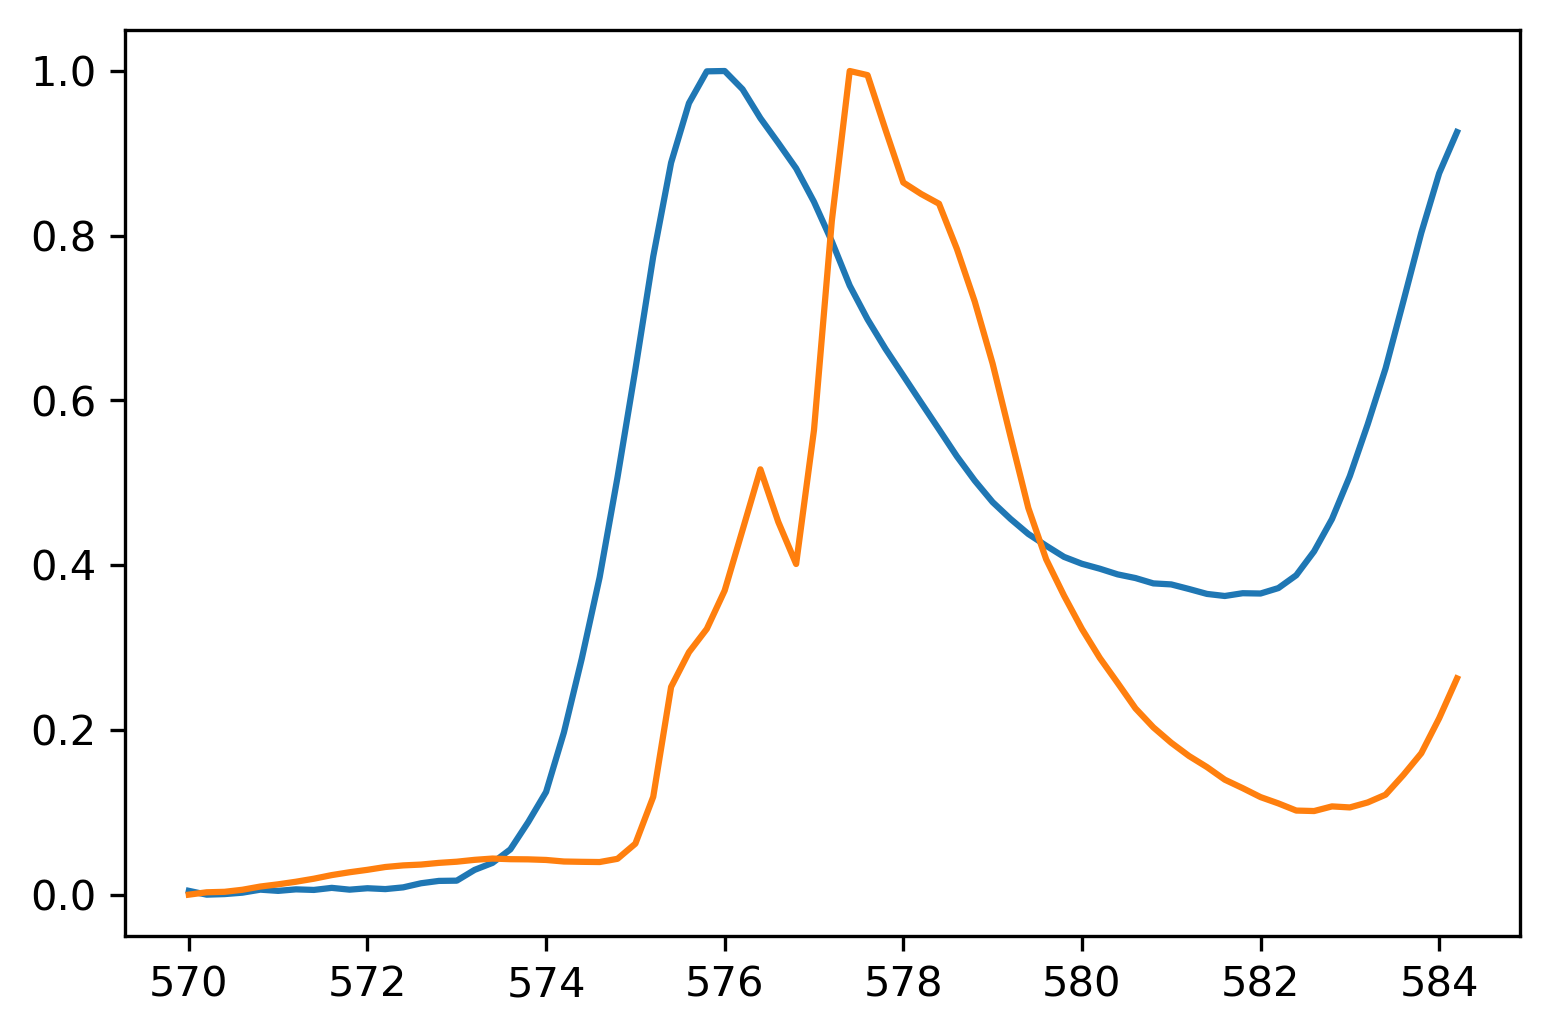

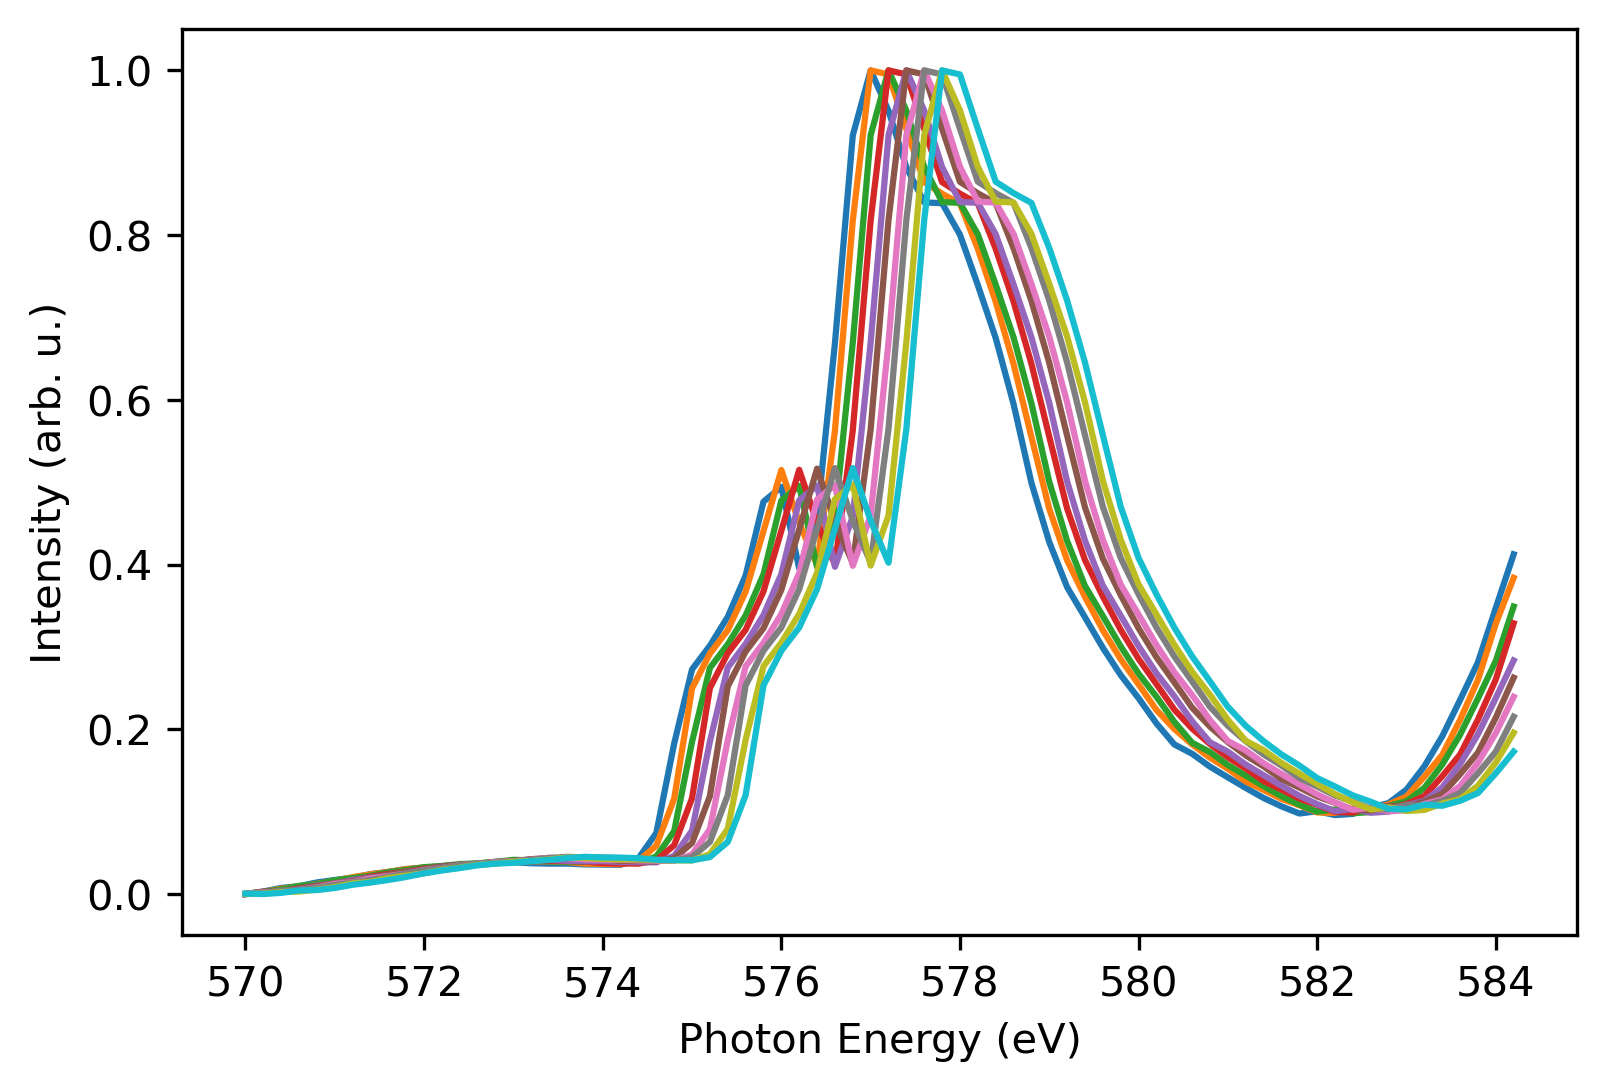

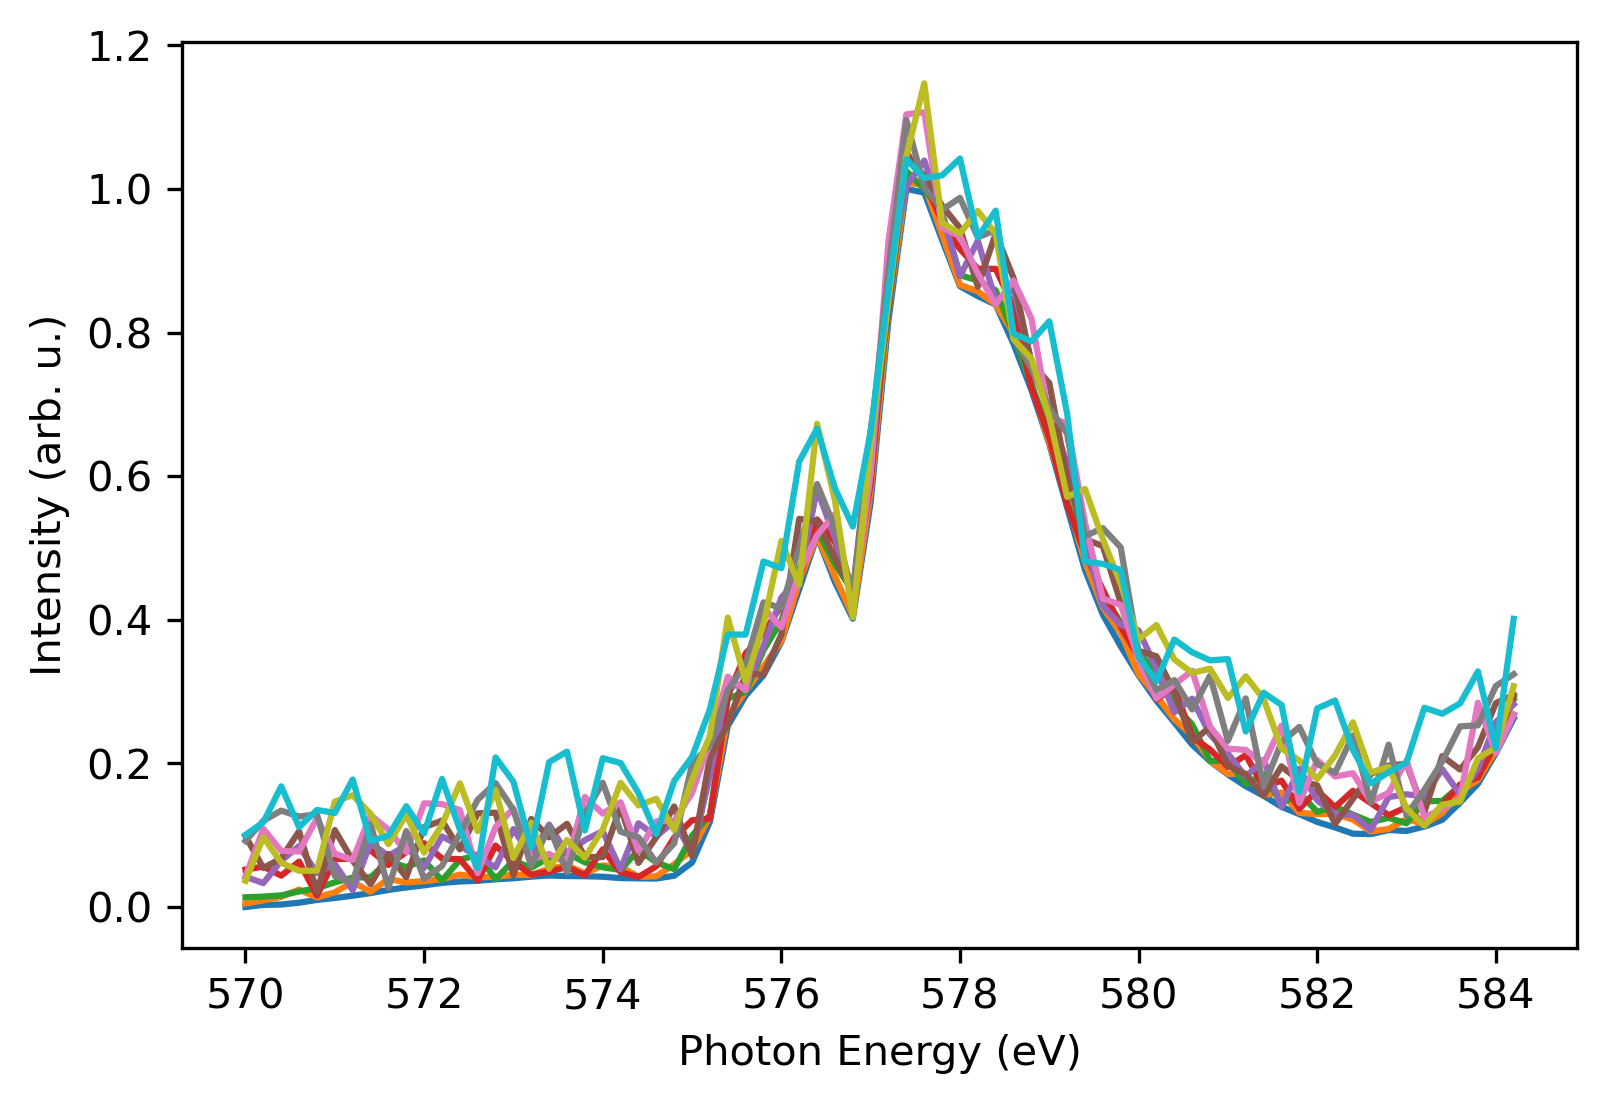

In [205]:
"""Make a batch of n random test spectra """
#Optionally add random noise
# noise = np.random.rand(synth_spectra.shape[0],synth_spectra.shape[1])*.05
# synth_spectra = synth_spectra+noise

n_tests = 100
noise_level = np.arange(0,.20,.02)
print(noise_level)
shifts = np.arange(-.5,.5,.1)
accuracies = np.zeros((shifts.shape[0],noise_level.shape[0]))

synth_spectra_list = np.zeros(n_tests)
labels = np.random.rand(n_tests)
predictions = np.zeros(n_tests)
xrange = np.arange(570,584.2,0.2)
static_metal_ref = normalize_array(metal_ref_interp(xrange))
static_oxide_ref = normalize_array(oxide_ref_interp(xrange))

plt.plot(xrange,metal_ref)
plt.plot(xrange,oxide_ref)
plt.show()

for shift in shifts:
    plt.plot(xrange, make_synth_spectra(oxide_ref_interp,shift))
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")
plt.show()
    
for n in noise_level:
    noise = np.random.rand(make_synth_spectra(oxide_ref_interp,shift=0).shape[0])*n
    plt.plot(xrange, make_synth_spectra(oxide_ref_interp,shift=0)+noise)

plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")
plt.show()


In [193]:
#Test the accuracy of the model
for k,shift in enumerate(shifts):

    metal_ref_shift = make_synth_spectra(metal_ref_interp,shift)
    oxide_ref_shift = make_synth_spectra(oxide_ref_interp,shift)
    synth_spectra = make_test_synths(metal_ref_shift,oxide_ref_shift,n_tests,labels)
    
    # plt.plot(metal_ref_shift)
    # plt.plot(oxide_ref_shift)
    # plt.plot(static_oxide_ref)
    # plt.plot(static_metal_ref)
    # print(cosine_similarity_2d(metal_ref_shift,static_metal_ref))
    # print(cosine_similarity_2d(oxide_ref_shift,static_oxide_ref))
    # plt.show()

    for j,n in enumerate(noise_level):
        noise = np.random.rand(synth_spectra.shape[0],synth_spectra.shape[1])*n
        noisy_spectra = synth_spectra+noise
        #plt.plot(xrange,noisy_spectra[3,:])

        #Calculate normalized cosine similarities for each synthetic mixture
        for i, row in enumerate(noisy_spectra):
            metal_cs = cosine_similarity_2d(row,static_metal_ref)
            oxide_cs = cosine_similarity_2d(row,static_oxide_ref)
            #predictions[i] = 1-oxide_cs_to_percent(oxide_cs/(metal_cs+oxide_cs))/100
            predictions[i] = 1-oxide_cs_to_percent_polyfit(oxide_cs/(metal_cs+oxide_cs))
        accuracies[k,j] = mean_absolute_error(labels,predictions)
        #plt.scatter(predictions,labels)

    #plt.show()

# for i in range(5):
#     plt.plot(xrange,synth_spectra[i,:])
#     plt.legend(np.round(labels[:5],2))

# plt.show()


Text(139.16666666666669, 0.5, 'Spectral shift (eV)')

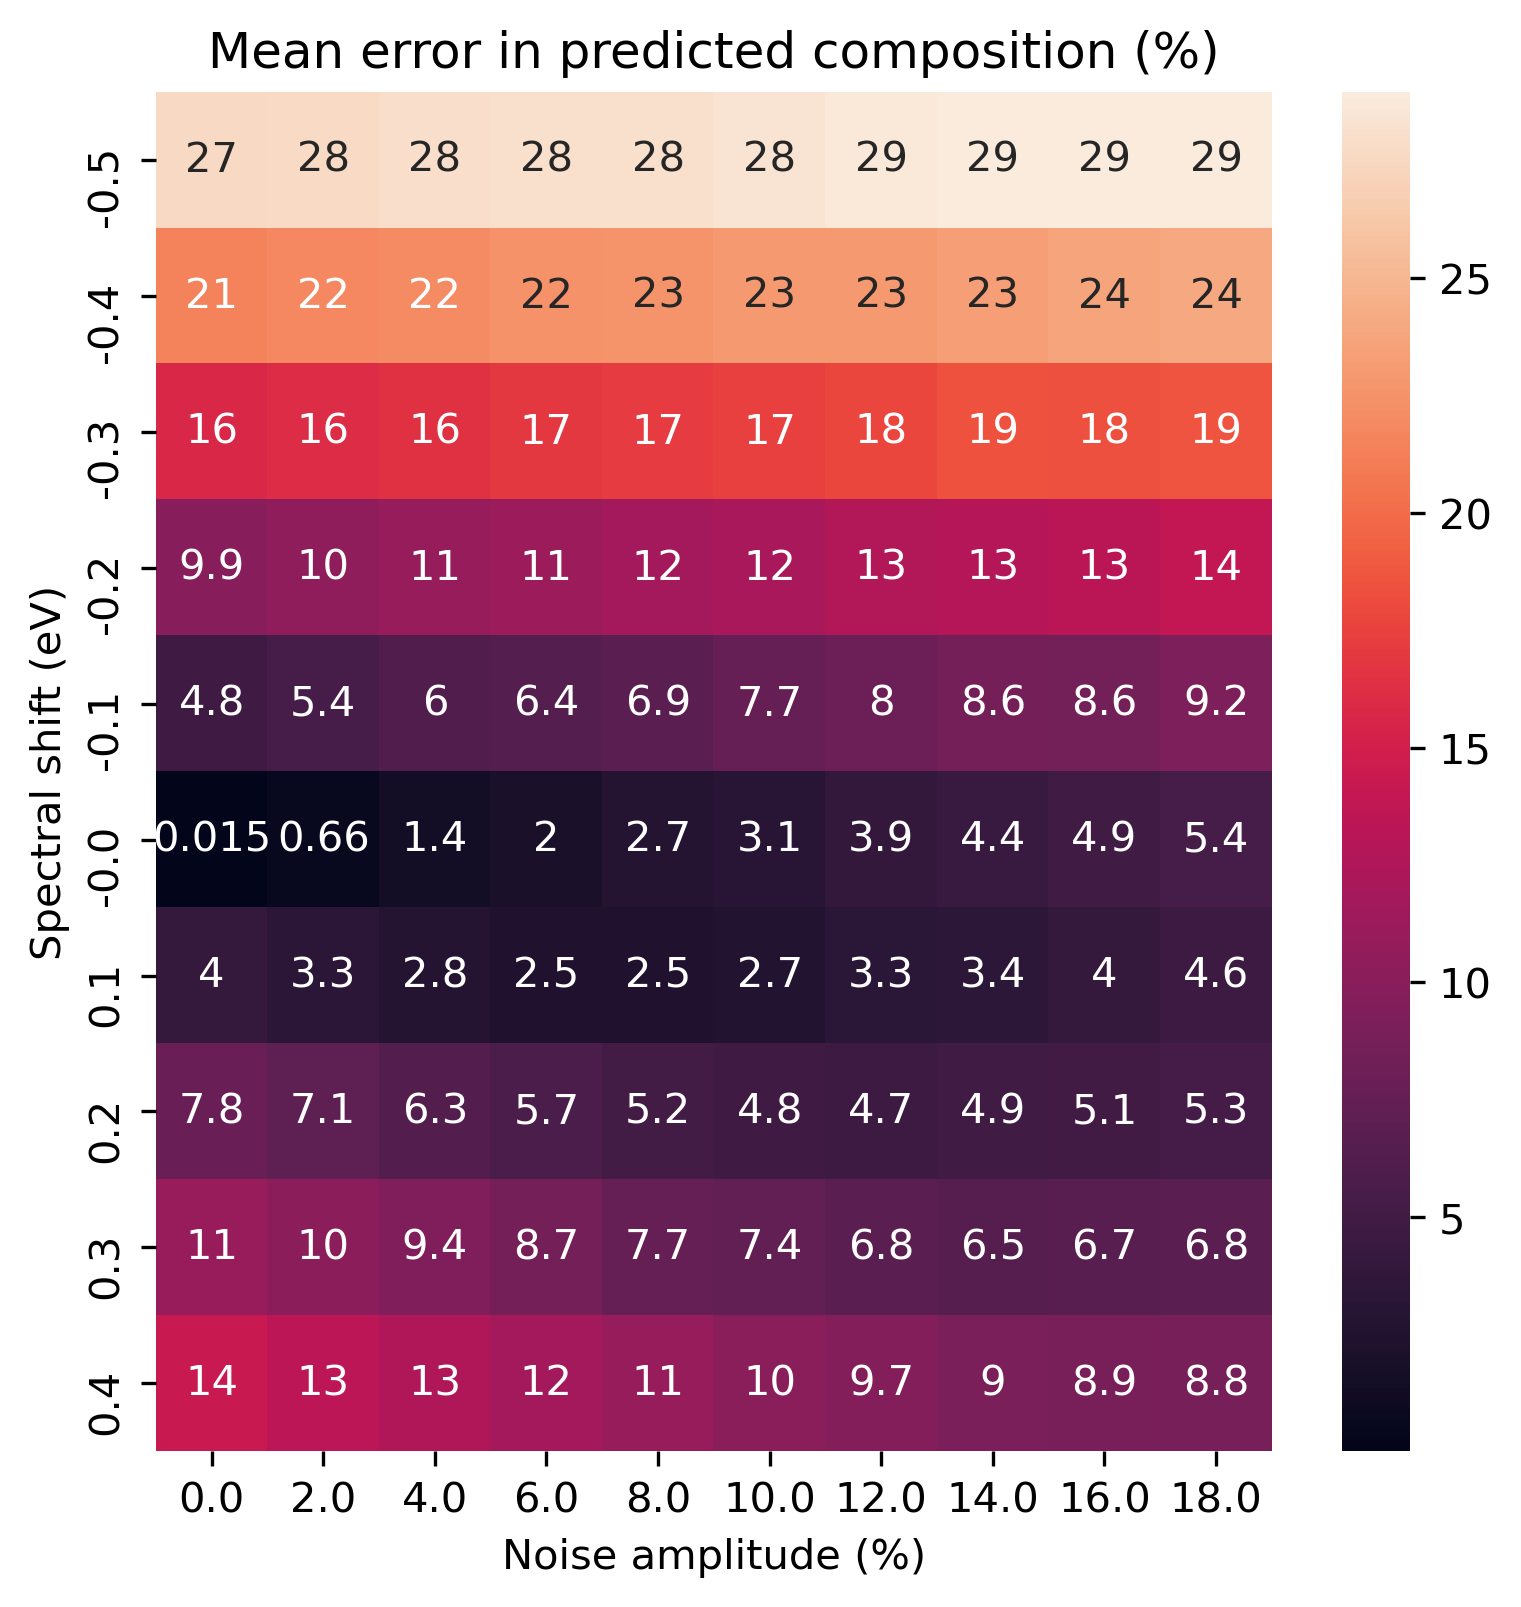

In [204]:
fig, ax = plt.subplots(figsize= (6, 6))

heatmap(accuracies*100,yticklabels= np.round(shifts,1),xticklabels=np.round(noise_level*100,0),annot=True)

plt.title('Mean error in predicted composition (%)')
plt.xlabel("Noise amplitude (%)")
plt.ylabel("Spectral shift (eV)")
